In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph. 

import plotly.express as px

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# construct labels for columns 
def constructCols(len):
    feature_cols = []
    for i in range(0,len):
        feature_cols.append('Feature{}'.format(i))

    return feature_cols


def distance_from_center(feature1,feature2, label, model):
#   Calculate the Euclidean distance between a data point and the center of its cluster.
    feature1_center =  model.cluster_centers_[label,0]
    feature2_center =  model.cluster_centers_[label,1]
    distance = np.sqrt((feature1 - feature1_center) ** 2 + (feature2 - feature2_center) ** 2)
    return np.round(distance, 3)

# detect outliers abd indexes
def detect_outliers(r_data):
    outliers = []
    outlier_idx = []
    data = sorted(r_data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    for idx, i in enumerate(r_data): 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
            outlier_idx.append(idx)

    return outliers, outlier_idx

In [4]:
# load the data
greypartridge_data = pd.read_csv('D:/UK/assignment/DSA8023/Analython_2/greypartridge/greypartridge_features.csv')
stockdove_data = pd.read_csv('D:/UK/assignment/DSA8023/Analython_2/stockdove/stockdove_features.csv')
turtledove_data = pd.read_csv('D:/UK/assignment/DSA8023/Analython_2/turtledove/turtledove_features.csv')
yellowhammer_data = pd.read_csv('D:/UK/assignment/DSA8023/Analython_2/yellowhammer/yellowhammer_features.csv')

In [28]:
# label the bird column
turtledove_data['bird'] = 0
greypartridge_data['bird'] = 1
yellowhammer_data['bird'] = 2
stockdove_data['bird'] = 3

bird_df_raw = pd.concat([turtledove_data, greypartridge_data, yellowhammer_data, stockdove_data]).reset_index(drop=True)

bird_df = bird_df_raw.drop(columns=['Unnamed: 0', 'bird', 'clip'])


In [29]:
bird_df.describe().T

,count,mean,std,min,25%,50%,75%,max
zcr_mean,4000.0,0.091769,0.080141,0.0,0.027957,0.069213,0.131529,0.600757
energy_mean,4000.0,0.025225,0.020509,0.0,0.008869,0.019994,0.037150,0.146312
energy_entropy_mean,4000.0,2.977298,0.204193,0.0,2.810897,3.011240,3.139923,3.308648
spectral_centroid_mean,4000.0,0.167472,0.076397,0.0,0.107946,0.148718,0.209444,0.533820
spectral_spread_mean,4000.0,0.187509,0.041473,0.0,0.154301,0.185886,0.214544,0.331338
...,...,...,...,...,...,...,...,...
delta chroma_9_std,4000.0,0.005924,0.006775,0.0,0.001475,0.003488,0.007553,0.049211
delta chroma_10_std,4000.0,0.008565,0.009337,0.0,0.002591,0.005243,0.010606,0.071783
delta chroma_11_std,4000.0,0.016833,0.013740,0.0,0.006606,0.012775,0.023401,0.126624
delta chroma_12_std,4000.0,0.007191,0.009720,0.0,0.001298,0.003696,0.008498,0.080783


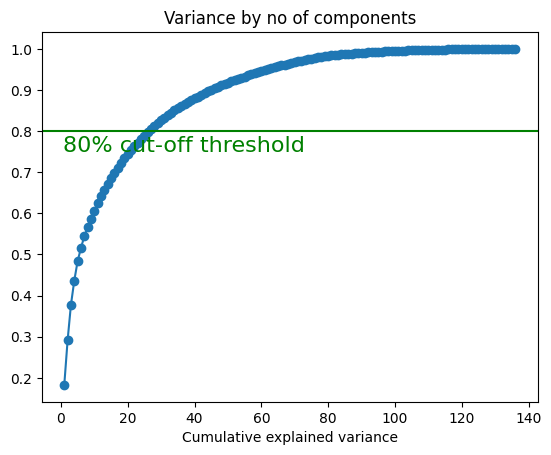

shape of pca (4000, 27)


In [47]:

from sklearn.decomposition import PCA

df_0 = bird_df.copy()

scaler = StandardScaler()
data_rescaled = scaler.fit_transform(df_0)

pca = PCA(0.8)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

pca = PCA(n_components=len(df_0.columns))
pca.fit_transform(data_rescaled)

plt.figure()
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')

plt.title('Variance by no of components')
plt.xlabel('No of components')
plt.xlabel('Cumulative explained variance')

plt.axhline(y=0.80, color='g', linestyle='-')
plt.text(0.5, 0.75, '80% cut-off threshold', color = 'green', fontsize=16)

plt.show()

print('shape of pca {}'.format(reduced.shape))

In [45]:
pca.explained_variance_ratio_.cumsum()

array([0.18269598, 0.29138388, 0.37777733, 0.43652864, 0.48382382,
       0.51574708, 0.54440826, 0.56597965, 0.58629845, 0.60546186,
       0.62412948, 0.64169812, 0.6576554 , 0.6724115 , 0.68570838,
       0.6983945 , 0.71080842, 0.72283376, 0.73412421, 0.74415146,
       0.75361754, 0.76287993, 0.77176956, 0.78060985, 0.78881183,
       0.79678798, 0.80450269, 0.81192924, 0.81907457, 0.82614928,
       0.83272675, 0.83884513, 0.84477616, 0.85031783, 0.85578328,
       0.86102098, 0.86591883, 0.87075263, 0.87542598, 0.87991898,
       0.88422795, 0.88841788, 0.89251597, 0.89648291, 0.90035947,
       0.90410821, 0.90774138, 0.91129055, 0.91480519, 0.91792705,
       0.92102377, 0.92401963, 0.9269737 , 0.92984511, 0.9326858 ,
       0.93545557, 0.93814956, 0.94078983, 0.94335296, 0.94589402,
       0.94840861, 0.95081694, 0.95319121, 0.95543594, 0.95764396,
       0.95980938, 0.96196279, 0.96405662, 0.96607424, 0.96800341,
       0.96980283, 0.97151413, 0.97315086, 0.97473226, 0.97626

In [48]:
# final_df = pd.DataFrame(reduced, columns=constructCols(len(reduced[0])))

# df_2 = final_df.copy()

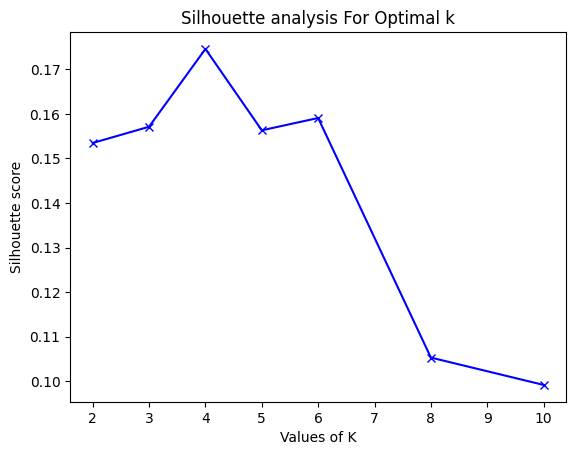

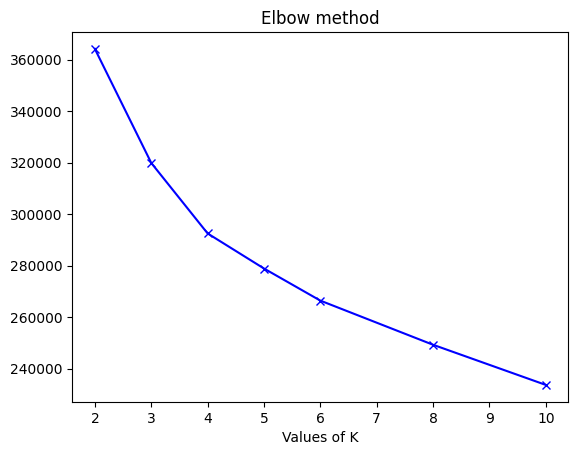

In [56]:
pca_features = 27

range_n_clusters = [2, 3, 4, 5, 6, 8 , 10]
silhouette_avg = []
wcss = []


df_1 = bird_df.copy()

scaler = StandardScaler()
df_1 = scaler.fit_transform(df_1)

pca_mod = PCA(n_components=pca_features, random_state=143)

pca_mod.fit(df_1)
mod_t = pca_mod.transform(df_1)


for num_clusters in range_n_clusters:
 
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    kmeans.fit(mod_t)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(df_1, cluster_labels))
    wcss.append(kmeans.inertia_)

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

# elbow method
plt.plot(range_n_clusters, wcss, 'bx-') 
plt.xlabel('Values of K') 
plt.title('Elbow method')
plt.show()

3    1369
0    1253
2     758
1     620
Name: cluster_label, dtype: int64


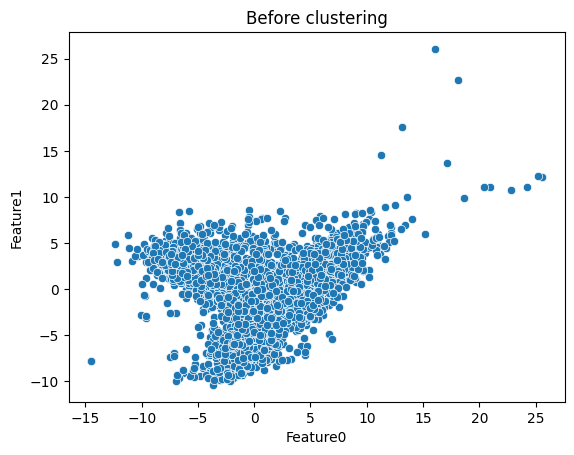

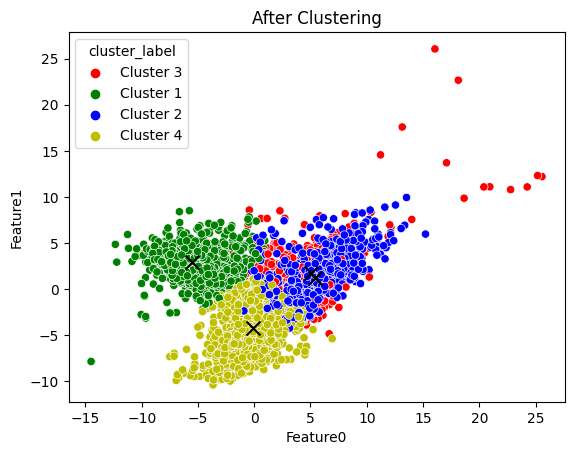

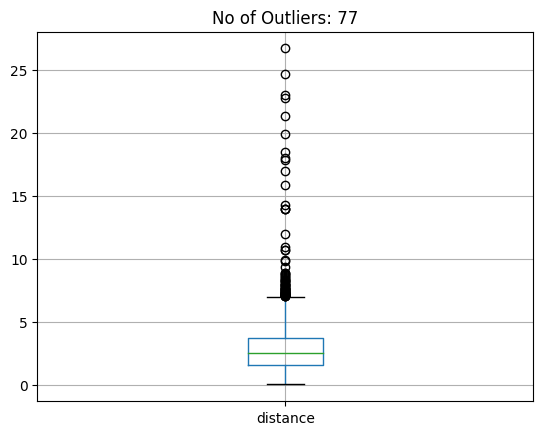

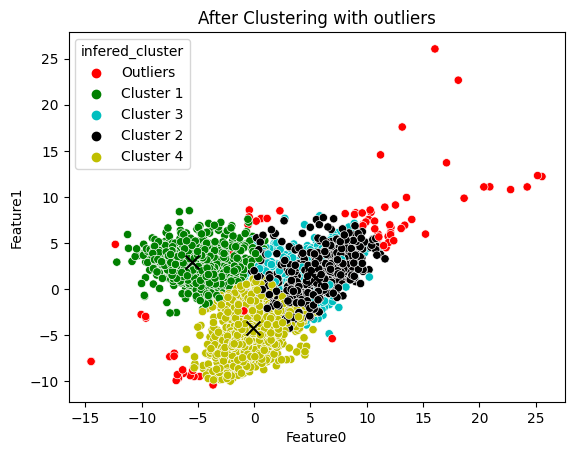

In [59]:
# we can consider no of classes as 4

mod_df = bird_df.copy()

scaler = StandardScaler()
data_rescaled = scaler.fit_transform(mod_df)

mod_df = pd.DataFrame(data_rescaled, columns=mod_df.columns)

pca_mod = PCA(n_components=pca_features)

pca_mod.fit(mod_df)
mod_t = pca_mod.transform(mod_df)

k_mod = KMeans(n_clusters=4, n_init = 10, init='k-means++', random_state=42)

classes = k_mod.fit_predict(mod_t)

final_df = pd.concat([mod_df.reset_index(drop=True), pd.DataFrame(mod_t, columns=constructCols(pca_features))], axis=1)
final_df['cluster_label'] = k_mod.labels_
final_df['distance'] = distance_from_center(final_df['Feature0'], final_df['Feature1'], final_df['cluster_label'], k_mod)
centroids = np.array(k_mod.cluster_centers_)

print(final_df['cluster_label'].value_counts())

outliers, all_outlier_idx = detect_outliers(final_df['distance'])
outliers_idx = list(final_df.sort_values('distance', ascending=False).head(len(all_outlier_idx)).index)

no_of_outliers = len(outliers_idx)

final_df['infered_cluster'] = k_mod.labels_
final_df.loc[outliers_idx, ['infered_cluster']] = 4

outliers_df = final_df[final_df.index.isin(outliers_idx)]

final_df['cluster_label'] = final_df['cluster_label'].replace({0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4'})
final_df['infered_cluster'] = final_df['infered_cluster'].replace({0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4', 4: 'Outliers'})
final_df['bird'] = bird_df_raw['bird'].replace({0:'turtledove', 1:'greypartridge', 2:'yellowhammer', 3:'stockdove'})

plt.figure()
sns.scatterplot(data = final_df, x='Feature0', y='Feature1') # ,palette=['r','g','b','y'])
plt.title('Before clustering')
plt.show()

# plot 2D scatter plot to cluster
plt.figure()
sns.scatterplot(data = final_df, x='Feature0', y='Feature1', hue="cluster_label", palette=['r','g','b','y'])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='k', s=100)
plt.title('After Clustering')
plt.show()


plt.figure()
final_df.boxplot(column=['distance'])
plt.title('No of Outliers: {}'.format(len(all_outlier_idx))) 
plt.suptitle('') # that's what you're after
plt.show()
                

# plot 2D scatter plot to cluster
plt.figure()
sns.scatterplot(data = final_df, x='Feature0', y='Feature1', hue="infered_cluster", palette=['r','g','c','k','y'])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='k', s=100)
plt.title('After Clustering with outliers')
plt.show()
                                  

                                                               
fig = px.scatter_3d(final_df, x='Feature0', y='Feature1', z='Feature2',color='infered_cluster', color_discrete_sequence=['red','green', 'cyan','black','yellow'])
fig.show()


In [ ]:
# no_of_outliers

In [ ]:
# since we determined 4 clusters


In [ ]:
# bird_df.boxplot(column=[ 'zcr_mean'])





In [ ]:
# for i in range(0,4):
#     temp_df = final_df[final_df.cluster_label == i ]
#     print(temp_df)
#     no_of_outlier = detect_outliers_iqr(temp_df['distance'])
#     temp_df.boxplot(column=['distance'])
#     print(no_of_outlier)
#     if no_of_outlier > 0:
#          outliers_idx.extend(list(temp_df.sort_values('distance', ascending=False).head(no_of_outlier).index))


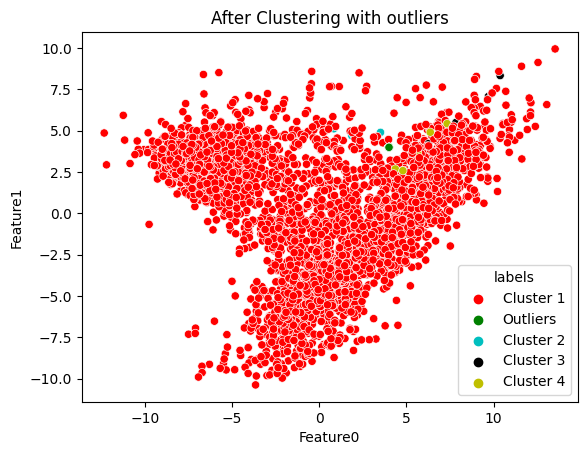

{-1, 0, 1, 2, 3}

In [55]:
# # dbscan method

# df_3 = bird_df.copy()

# mod_df = df_3.drop(columns=['Unnamed: 0', 'bird', 'clip'])

# scaler = StandardScaler()
# X = scaler.fit_transform(mod_df)

# mod_df = pd.DataFrame(X, columns=mod_df.columns)

# pca_mod = PCA(n_components=27)

# pca_mod.fit(mod_df)
# mod_t = pca_mod.transform(mod_df)

# mod_t = pd.DataFrame(mod_t, columns=constructCols(27))

# # Apply DBSCAN clustering
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps= 7.2, min_samples=5)
# mod_t['labels'] = dbscan.fit_predict(mod_t)

# mod_t[mod_t['labels'] == -1 ] = 4

# mod_t['labels'] = mod_t['labels'].replace({0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4', 4: 'Outliers'})


# # # Visualize clustering results
# plt.figure()
# sns.scatterplot(data = mod_t, x='Feature0', y='Feature1', hue="labels", palette=['r','g','c','k','y'])
# # plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='k', s=100)
# plt.title('After Clustering with outliers')
# plt.show()

# fig = px.scatter_3d(mod_t, x='Feature0', y='Feature1', z='Feature2',color='labels', color_discrete_sequence=['red','green', 'cyan','black','yellow'])
# fig.show()


# # Evaluate clustering results
# # from sklearn.metrics import silhouette_score
# # score = silhouette_score(X, dbscan.labels_)
# # print("Silhouette score:", score)
# set(dbscan.labels_.tolist())



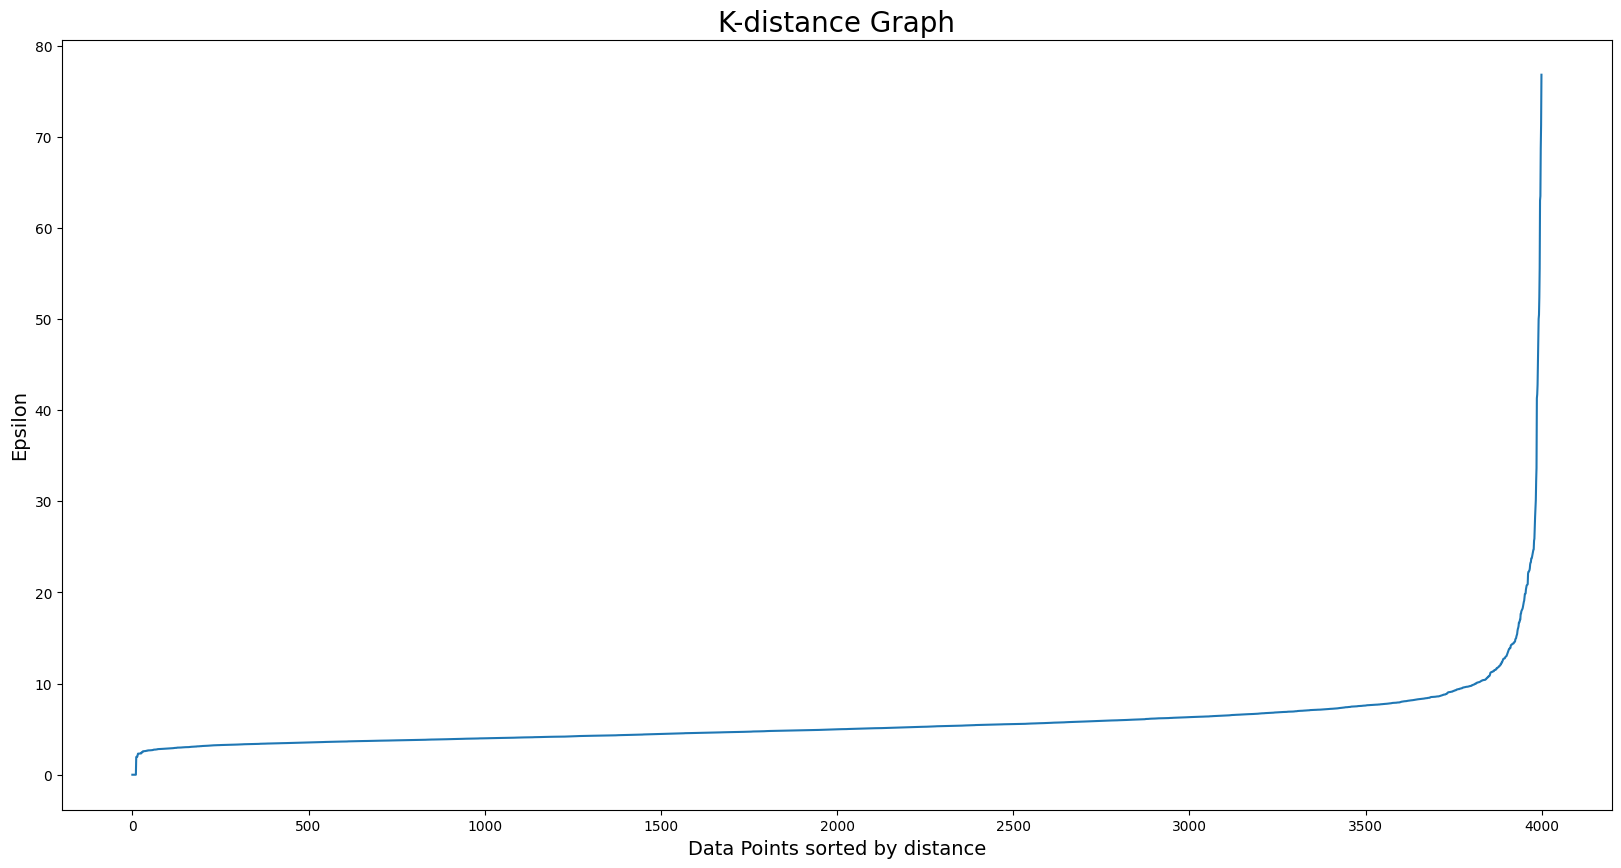

In [39]:
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=2)
# nbrs = neigh.fit(mod_df)
# distances, indices = nbrs.kneighbors(mod_df)


# # Plotting K-distance Graph
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.figure(figsize=(20,10))
# plt.plot(distances)
# plt.title('K-distance Graph',fontsize=20)
# plt.xlabel('Data Points sorted by distance',fontsize=14)
# plt.ylabel('Epsilon',fontsize=14)
# plt.show()

In [ ]:

# def strip_clip_label(s):
#     return s.split('-')[2].split('_')[0]

# bird_df['clip'] = bird_df['clip'].apply(strip_clip_label)
